In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deepMacroFin import PDEModel
from deepMacroFin import ActivationType, Comparator, Constraint, EndogVar, EndogVarConditions, EndogEquation, System

## Model 1
$$\begin{cases}\frac{dx}{dt} = t, t\geq 0 \\ \frac{dx}{dt} = 0, t < 0\end{cases}, t\in[-1,1], x(0)= 1$$

Solution: $\begin{cases}\frac{1}{2}t^2+1, t\geq 0\\ 1, t<0\end{cases}$

In [2]:
constrained_problem = PDEModel("constrained_1", {"num_epochs": 2000})
constrained_problem.set_state(["t"], {"t": [-1., 1.]})
constrained_problem.add_endog("x", config={
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "hidden_units": [50, 50, 50],
    "activation_type": ActivationType.SiLU,
    "positive": False,
    "derivative_order": 2,
})
sys = System([Constraint("t", Comparator.GEQ, "0", label="pos")], "pos")
sys.add_endog_equation("x_t=t")
sys2 = System([Constraint("t", Comparator.LT, "0", label="neg")], "neg")
sys.add_endog_equation("x_t=0")
constrained_problem.add_system(sys)
constrained_problem.add_system(sys2)
constrained_problem.add_endog_condition("x", 
                                        "x(SV)", {"SV": torch.zeros((1, 1))},
                                        Comparator.EQ,
                                        "1", {},
                                        "ic")
print(constrained_problem)
if not os.path.exists("./models/constrained_problem1.pt"):
    constrained_problem.train_model("./models", "constrained_problem1.pt", True)
    constrained_problem.eval_model(True)
else:
    constrained_problem.load_model(torch.load("./models/constrained_problem1.pt"))
    constrained_problem.eval_model(True)

=========================Summary of Model constrained_1=========================
Config: {
 "batch_size": 100,
 "num_epochs": 2000,
 "lr": 0.001
}
Latex Variable Mapping: {}

================================State Variables=================================
t: [-1.0, 1.0]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: x
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=1, out_features=50, bias=True)
    (activation_0): SiLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (activation_1): SiLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (activation_2): SiLU()
    (final_layer): Linear(in_features=50, out_features=1, bias=True)
  )
)
Num parameters: 5251
---------------------------------------------

Total loss: 0.1528: 100%|██████████| 2000/2000 [00:16<00:00, 120.35it/s]

training finished, total time :: 16.621381759643555
Model saved to ./models/constrained_problem1.pt
===================================Evaluating===================================
loss :: system_pos: 0.1391,
system_neg: 0.0000,
endogvar_x_cond_ic: 0.0000,
total_loss: 0.1391


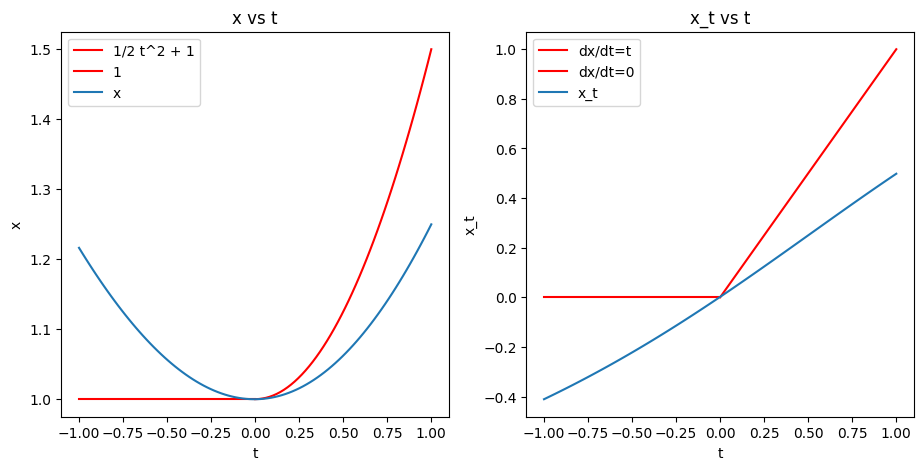

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
t = np.linspace(-1, 1)
t_pos = np.linspace(0, 1)
t_neg = np.linspace(-1, 0)
ax[0].plot(t_pos, 0.5 * t_pos**2 + 1, label="1/2 t^2 + 1", color="red")
ax[0].plot(t_neg, np.ones_like(t_neg), label="1", color="red")
ax[1].plot(t_pos, t_pos, label="dx/dt=t", color="red")
ax[1].plot(t_neg, np.zeros_like(t_neg), label="dx/dt=0", color="red")
constrained_problem.endog_vars["x"].plot("x", {"t": [-1, 1]}, ax=ax[0])
constrained_problem.endog_vars["x"].plot("x_t", {"t": [-1, 1]}, ax=ax[1])
plt.subplots_adjust()
plt.show()